# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

<div id="fix_1" style="border:solid blue 2px; padding: 20px">
    
### Содержание исследования
_____

##### Предобработка данных:
* <a href="#step_1">1. Изученеие файлов с данными, получение общей информации, загрузка библиотек.</a>
* <a href="#step_2">2. Нахождение и ликвидация пропусков.</a>
* <a href="#step_3">3. Дополнительные расчёты и добавление данных.</a>

##### Исследовательский анализ данных:
* <a href="#step_41">4.1 Изучение параметров: площадь, цена, число комнат, высота потолков.</a>
* <a href="#step_42">4.2 Построение гистрограмм для параметров: площадь, цена, число комнат, высота потолков.</a>
* <a href="#step_43">4.3 Изучение времени продажи квартир.</a>
* <a href="#step_44">4.4 Удаление редких и выбивающихся значений.</a>
* <a href="#step_45">4.5 Какие факторы больше всего влияют на стоимость квартиры.</a>
* <a href="#step_46">4.6 Изучение расстояния до центра квартир в Санкт-Петербурге.</a>
* <a href="#step_46">4.7 Анализ сегмента квартир в центре.</a>

##### Итог:
* <a href="#step_5">5. Общий вывод</a>
</div>

<a id='step_1'></a>
### 1. Изученеие файлов с данными, получение общей информации, загрузка библиотек:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Глобально снял ограничение на кол-во выводов для каждой ячейки ввода кода.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Включил возможность форматировать стили текста с помощью метода printmd()
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
#Снял ограничение на вывод кол-ва столбцов и ширины колонки.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

#Обнаружил, что данные записаны в одну строку. 
#В атрибуте sep указал разделитель.
#Атрибут engine='python' указывает используемый движок парсера.
#Отсортировал колонки по наименованию id.
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t', engine='python').sort_index(axis=1)
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
airports_nearest        18157 non-null float64
balcony                 12180 non-null float64
ceiling_height          14504 non-null float64
cityCenters_nearest     18180 non-null float64
days_exposition         20518 non-null float64
first_day_exposition    23699 non-null object
floor                   23699 non-null int64
floors_total            23613 non-null float64
is_apartment            2775 non-null object
kitchen_area            21421 non-null float64
last_price              23699 non-null float64
living_area             21796 non-null float64
locality_name           23650 non-null object
open_plan               23699 non-null bool
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around3000        18181 non-null float64
ponds_nearest           9110 non-null float64
rooms                   23699 non-null int64
studio     

,airports_nearest,balcony,ceiling_height,cityCenters_nearest,days_exposition,first_day_exposition,floor,floors_total,is_apartment,kitchen_area,last_price,living_area,locality_name,open_plan,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,rooms,studio,total_area,total_images
0,18863.0,NaN,2.70,16028.0,NaN,2019-03-07T00:00:00,8,16.0,NaN,25.00,13000000.0,51.00,Санкт-Петербург,False,1.0,482.0,2.0,755.0,3,False,108.00,20
1,12817.0,2.0,NaN,18603.0,81.0,2018-12-04T00:00:00,1,11.0,NaN,11.00,3350000.0,18.60,посёлок Шушары,False,0.0,NaN,0.0,NaN,1,False,40.40,7
2,21741.0,0.0,NaN,13933.0,558.0,2015-08-20T00:00:00,4,5.0,NaN,8.30,5196000.0,34.30,Санкт-Петербург,False,1.0,90.0,2.0,574.0,2,False,56.00,10
3,28098.0,0.0,NaN,6800.0,424.0,2015-07-24T00:00:00,9,14.0,NaN,NaN,64900000.0,NaN,Санкт-Петербург,False,2.0,84.0,3.0,234.0,3,False,159.00,0
4,31856.0,NaN,3.03,8098.0,121.0,2018-06-19T00:00:00,13,14.0,NaN,41.00,10000000.0,32.00,Санкт-Петербург,False,2.0,112.0,1.0,48.0,2,False,100.00,2
5,NaN,NaN,NaN,NaN,55.0,2018-09-10T00:00:00,5,12.0,NaN,9.10,2890000.0,14.40,городской посёлок Янино-1,False,NaN,NaN,NaN,NaN,1,False,30.40,10
6,52996.0,1.0,NaN,19143.0,155.0,2017-11-02T00:00:00,6,26.0,NaN,14.40,3700000.0,10.60,посёлок Парголово,False,0.0,NaN,0.0,NaN,1,False,37.30,6
7,23982.0,2.0,NaN,11634.0,NaN,2019-04-18T00:00:00,22,24.0,NaN,18.90,7915000.0,NaN,Санкт-Петербург,False,0.0,NaN,0.0,NaN,2,False,71.60,5
8,NaN,NaN,NaN,NaN,189.0,2018-05-23T00:00:00,26,27.0,NaN,8.81,2900000.0,15.43,посёлок Мурино,False,NaN,NaN,NaN,NaN,1,False,33.16,20
9,50898.0,2.0,2.50,15008.0,289.0,2017-02-26T00:00:00,7,9.0,NaN,6.50,5400000.0,43.60,Санкт-Петербург,False,0.0,NaN,0.0,NaN,3,False,61.00,18


In [2]:
#Вывел уникальные значения столбцов, для проверки корректности данных. 
#Применил try except для обхода ошибок сортировки. Сортировал значения там, где это возможно.
a = []
for column in data.columns:
    print(column,':')
    a = data[column].unique()
    try:
        a.sort()
    except:
        print(a)
    else:
        print(a)
    print()
data.head(5)

airports_nearest :
[    0.  6450.  6914. ... 84853. 84869.    nan]

balcony :
[ 0.  1.  2.  3.  4.  5. nan]

ceiling_height :
[  1.     1.2    1.75   2.     2.2    2.25   2.3    2.34   2.4    2.45
   2.46   2.47   2.48   2.49   2.5    2.51   2.52   2.53   2.54   2.55
   2.56   2.57   2.58   2.59   2.6    2.61   2.62   2.63   2.64   2.65
   2.66   2.67   2.68   2.69   2.7    2.71   2.72   2.73   2.74   2.75
   2.76   2.77   2.78   2.79   2.8    2.81   2.82   2.83   2.84   2.85
   2.86   2.87   2.88   2.89   2.9    2.91   2.92   2.93   2.94   2.95
   2.96   2.97   2.98   2.99   3.     3.01   3.02   3.03   3.04   3.05
   3.06   3.07   3.08   3.09   3.1    3.11   3.12   3.13   3.14   3.15
   3.16   3.17   3.18   3.2    3.21   3.22   3.23   3.24   3.25   3.26
   3.27   3.28   3.29   3.3    3.31   3.32   3.33   3.34   3.35   3.36
   3.37   3.38   3.39   3.4    3.42   3.43   3.44   3.45   3.46   3.47
   3.48   3.49   3.5    3.51   3.52   3.53   3.54   3.55   3.56   3.57
   3.58   3.59   3.6  

,airports_nearest,balcony,ceiling_height,cityCenters_nearest,days_exposition,first_day_exposition,floor,floors_total,is_apartment,kitchen_area,last_price,living_area,locality_name,open_plan,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,rooms,studio,total_area,total_images
0,18863.0,NaN,2.70,16028.0,NaN,2019-03-07T00:00:00,8,16.0,NaN,25.0,13000000.0,51.0,Санкт-Петербург,False,1.0,482.0,2.0,755.0,3,False,108.0,20
1,12817.0,2.0,NaN,18603.0,81.0,2018-12-04T00:00:00,1,11.0,NaN,11.0,3350000.0,18.6,посёлок Шушары,False,0.0,NaN,0.0,NaN,1,False,40.4,7
2,21741.0,0.0,NaN,13933.0,558.0,2015-08-20T00:00:00,4,5.0,NaN,8.3,5196000.0,34.3,Санкт-Петербург,False,1.0,90.0,2.0,574.0,2,False,56.0,10
3,28098.0,0.0,NaN,6800.0,424.0,2015-07-24T00:00:00,9,14.0,NaN,NaN,64900000.0,NaN,Санкт-Петербург,False,2.0,84.0,3.0,234.0,3,False,159.0,0
4,31856.0,NaN,3.03,8098.0,121.0,2018-06-19T00:00:00,13,14.0,NaN,41.0,10000000.0,32.0,Санкт-Петербург,False,2.0,112.0,1.0,48.0,2,False,100.0,2


### Вывод

Вижу множество пропущенных значений в колонках. Типы данных во многих колонках object, тогда как удобнее использовать int64. По мере возможности, для более точной инфомарции требуется восстановить пропущенные значения и изменить тип данных.

Подробное описание с комментариями:

<table>
  <thead>
    <tr>
      <td style="text-align: left;"><b>id колонки</b></td>
      <td style="text-align: left;"><b>Описание</b></td>
      <td><b>Кол-во непустых значений</b></td>
      <td><b>Тип данных</b></td>
      <td style="text-align: left;"><b>Комментарий</b></td>
    </tr>
  </thead>
  <tr>
    <td style="text-align: left;">airports_nearest</td>
    <td style="text-align: left;">расстояние до ближайшего аэропорта в метрах (м)</td>
    <td>18157</td>
    <td>object</td>
    <td style="text-align: left;">Обратил внимание на записи 0 и NaN. Тип данных должен быть int64.</td>
  </tr>
  <tr>
    <td style="text-align: left;">balcony</td>
    <td style="text-align: left;">число балконов</td>
    <td>12180</td>
    <td>object</td>
    <td style="text-align: left;">Содержит NaN. Тип данных должен быть int64.</td>
  </tr>
  <tr>
    <td style="text-align: left;">ceiling_height</td>
    <td style="text-align: left;">высота потолков (м)</td>
    <td>14504</td>
    <td>float64</td>
    <td style="text-align: left;">Существуют очевидно слишком большие значения и NaN.</td>
  </tr>
  <tr>
    <td style="text-align: left;">cityCenters_nearest</td>
    <td style="text-align: left;">расстояние до центра города (м)</td>
    <td>18180</td>
    <td>object</td>
    <td style="text-align: left;">Есть поля NaN. Значения можно округлит типом данных int64.</td>
  </tr>
  <tr>
    <td style="text-align: left;">days_exposition</td>
    <td style="text-align: left;">сколько дней было размещено объявление (от публикации до снятия)</td>
    <td>20518</td>
    <td>float64</td>
    <td style="text-align: left;">Возможно NaN означает, что объявление еще размещены.</td>
  </tr>
  <tr>
    <td style="text-align: left;">first_day_exposition</td>
    <td style="text-align: left;">дата публикации</td>
    <td>23699</td>
    <td>object</td>
    <td style="text-align: left;">В значениях стоит избавиться от части 'T00:00:00', поскольку никакой информации эти данные не несут. Перевести тип данных в datetime</td>
  <tr>
    <td style="text-align: left;">floor</td>
    <td style="text-align: left;">этаж</td>
    <td>23699</td>
    <td>object</td>
    <td style="text-align: left;">Тип данных должен быть int64</td>
  </tr>
  <tr>
    <td style="text-align: left;">floors_total</td>
    <td style="text-align: left;">всего этажей в доме</td>
    <td>23613</td>
    <td>object</td>
    <td style="text-align: left;">Есть пропуски NaN. Тип данных должен быть int64</td>
  </tr>
  <tr>
    <td style="text-align: left;">is_apartment</td>
    <td style="text-align: left;">апартаменты (булев тип)</td>
    <td>2775</td>
    <td>object</td>
    <td style="text-align: left;">Есть пропуски NaN. Тип данных должен быть bool.</td>
  </tr>
  <tr>
    <td style="text-align: left;">kitchen_area</td>
    <td style="text-align: left;">площадь кухни в квадратных метрах (м²)</td>
    <td>21421</td>
    <td>float64</td>
    <td style="text-align: left;">Есть пропуски NaN.</td>
  </tr>
  <tr>
    <td style="text-align: left;">last_price</td>
    <td style="text-align: left;">цена на момент снятия с публикации</td>
    <td>23699</td>
    <td>float64</td>
    <td style="text-align: left;">Тип данных должен быть int64</td>
  </tr>
  <tr>
    <td style="text-align: left;">living_area</td>
    <td style="text-align: left;">жилая площадь в квадратных метрах(м²)</td>
    <td>21796</td>
    <td>object</td>
    <td style="text-align: left;">Есть пропуски NaN. Тип данных должен быть float64.</td>
  </tr>
  <tr>
    <td style="text-align: left;">locality_name</td>
    <td style="text-align: left;">название населённого пункта</td>
    <td>23650</td>
    <td>object</td>
    <td style="text-align: left;">Есть 44 ячейки NaN, а так же одни и те же населённые пункты записанные по разному.</td>
  </tr>
  <tr>
    <td style="text-align: left;">open_plan</td>
    <td style="text-align: left;">свободная планировка (булев тип)</td>
    <td>23699</td>
    <td>object</td>
    <td style="text-align: left;">Тип данных должен быть bool.</td>
  </tr>
  <tr>
    <td style="text-align: left;">parks_around3000</td>
    <td style="text-align: left;">число парков в радиусе 3 км</td>
    <td>18181</td>
    <td>object</td>
    <td style="text-align: left;">Есть поля NaN. Тип данных должен быть int64</td>
  </tr>
  <tr>
    <td style="text-align: left;">parks_nearest</td>
    <td style="text-align: left;">расстояние до ближайшего парка (м)</td>
    <td>8079</td>
    <td>object</td>
    <td style="text-align: left;">Необходимо перевести в числовое значение. Есть поля NaN. Тип данных должен быть int64</td>
  </tr>
  <tr>
    <td style="text-align: left;">ponds_around3000</td>
    <td style="text-align: left;">число водоёмов в радиусе 3 км</td>
    <td>18181</td>
    <td>float64</td>
    <td style="text-align: left;">Есть поля NaN. Тип данных может быть int64</td>
  </tr>
  <tr>
    <td style="text-align: left;">ponds_nearest</td>
    <td style="text-align: left;">расстояние до ближайшего водоёма (м)</td>
    <td>9110</td>
    <td>float64</td>
    <td style="text-align: left;">Есть поля NaN. Тип данных может быть int64.</td>
  </tr>
  <tr>
    <td style="text-align: left;">rooms</td>
    <td style="text-align: left;">число комнат</td>
    <td>23699</td>
    <td>int64</td>
    <td style="text-align: left;">Есть значения 0 и слишком большие значения.</td>
  </tr>
  <tr>
    <td style="text-align: left;">studio</td>
    <td style="text-align: left;">квартира-студия (булев тип)</td>
    <td>23699</td>
    <td>object</td>
    <td style="text-align: left;">Тип данных должен быть bool.</td>
  </tr>
  <tr>
    <td style="text-align: left;">total_area</td>
    <td style="text-align: left;">площадь квартиры в квадратных метрах (м²)</td>
    <td>23699</td>
    <td>float64</td>
    <td style="text-align: left;">На первый взгляд данные в порядке.</td>
  </tr>
  <tr>
    <td style="text-align: left;">total_images</td>
    <td style="text-align: left;">число фотографий квартиры в объявлении</td>
    <td>23699</td>
    <td>int64</td>
    <td style="text-align: left;">На первый взгляд данные в порядке.</td>
  </tr>
</table>

## <span style="color:green">Комментарий от ревьювера (все здОрово)</span>
Просто шикарные предварительные исследования и выводы. Последняя табличка - огонь) Мне нечего добавить, молодец, выше всяких похвал)

<a id='step_2'></a>
### 2. Нахождение и ликвидация пропусков:

In [3]:
print('Количество пропусков до обработки:')
print(data.isna().sum())
print()


#Значения NaN в колонках расстояний заменил на -1
data['ponds_around3000'].fillna('-1',inplace=True)
data['ponds_around3000'] = data['ponds_around3000'].astype('int64')

data['airports_nearest'].fillna('-1',inplace=True)
data['airports_nearest'] = data['airports_nearest'].astype('int64')

data['parks_around3000'].fillna('-1',inplace=True)
data['parks_around3000'] = data['parks_around3000'].astype('int64')

data['cityCenters_nearest'].fillna('-1',inplace=True)
data['cityCenters_nearest'] = data['cityCenters_nearest'].astype('int64')

from statistics import mode

#Изменил формат цены на целочисленный
data['last_price'] = data['last_price'].astype('int64')

#Колонку `день первого размещения` перевел в формат datetime
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])

#Значения NaN в `днях размещения` заменил на -1. Это значит, что объявление еще актуально.
data['days_exposition'].fillna('-1',inplace=True)
data['days_exposition'] = data['days_exposition'].astype('int64')

#Пропущенные значения апартаментов заменил на False
data['is_apartment'].fillna('False',inplace=True)

#Пропущенные значения кухонной площади заменил по моде для каждой группы 'rooms'.
data['kitchen_area'].fillna(mode(data[(data['rooms'] == data['rooms'])&(data['kitchen_area'] > 0)]['kitchen_area']),inplace=True)

#Пропущенные значения жилой площади заменил по моде для каждой группы 'rooms', а тип данных на float64.
data['living_area'].fillna(mode(data[(data['rooms'] == data['rooms'])&(data['living_area'] > 0)]['living_area']),inplace=True)
data['living_area'] = data['living_area'].astype('float64')

#Пропуски балконов заменил по моде для каждой группы 'rooms', а тип данных на int64.
data['balcony'].fillna(mode(data[(data['rooms'] == data['rooms'])&(data['balcony'] > 0)]['balcony']),inplace=True)
data['balcony'] = data['balcony'].astype('int64')

#Высоту потолков заменил по моде
data['ceiling_height'].fillna(mode(data['ceiling_height']),inplace=True)

print('Количество пропусков после обработки:')
print(data.isna().sum())
print()

Количество пропусков до обработки:
airports_nearest        5542 
balcony                 11519
ceiling_height          9195 
cityCenters_nearest     5519 
days_exposition         3181 
first_day_exposition    0    
floor                   0    
floors_total            86   
is_apartment            20924
kitchen_area            2278 
last_price              0    
living_area             1903 
locality_name           49   
open_plan               0    
parks_around3000        5518 
parks_nearest           15620
ponds_around3000        5518 
ponds_nearest           14589
rooms                   0    
studio                  0    
total_area              0    
total_images            0    
dtype: int64

Количество пропусков после обработки:
airports_nearest        0    
balcony                 0    
ceiling_height          0    
cityCenters_nearest     0    
days_exposition         0    
first_day_exposition    0    
floor                   0    
floors_total            86   
is_apartment 

### Вывод

Пропуски случайные, точную причину отстутствия данных установить не удается. Возможно были проблемы при записи или информация отсутствует.

Обработал пропуски там, где это требуется условиями задачи.

<a id='step_3'></a>
### 3. Дополнительные расчёты и добавление данных

In [4]:
#Добавил в таблицу цену квадратного метра
data['price_per_square'] = data['last_price'] / data['total_area']
data[['price_per_square']].head(3)

,price_per_square
0,120370.370370
1,82920.792079
2,92785.714286


In [5]:
#Добавил в таблицу день недели, месяц и год публикации объявления
data['year'] = data['first_day_exposition'].dt.year
data['month'] = data['first_day_exposition'].dt.month
data['day_of_week'] = data['first_day_exposition'].dt.dayofweek + 1
data[['first_day_exposition','day_of_week','month','year']].head(3)

,first_day_exposition,day_of_week,month,year
0,2019-03-07,4,3,2019
1,2018-12-04,2,12,2018
2,2015-08-20,4,8,2015


In [6]:
#Добавил в таблицу варианты — 1(первый), 2(другой), 3(последний). Цифровые значения для возможности построить корреляцию.
def floor_group(dataset):
    floor = dataset['floor']
    floors_total = dataset['floors_total']
    if 1 == floor:
        return 1
    if floors_total == floor:
        return 3
    return 2
data['floor_group'] = data.apply(floor_group, axis=1)
data[['floor','floors_total','floor_group']].head(5)

,floor,floors_total,floor_group
0,8,16.0,2
1,1,11.0,1
2,4,5.0,2
3,9,14.0,2
4,13,14.0,2


In [7]:
#Добавил в таблицу соотношения жилой и общей площади, а также отношения площади кухни к общей.
data['living_area_ratio'] = data['living_area'] / data['total_area']
data[['living_area','total_area','living_area_ratio']].head(3)

data['kitchen_area_ratio'] = data['kitchen_area'] / data['total_area']
data[['kitchen_area','total_area','kitchen_area_ratio']].head(3)

,living_area,total_area,living_area_ratio
0,51.0,108.0,0.472222
1,18.6,40.4,0.460396
2,34.3,56.0,0.612500


,kitchen_area,total_area,kitchen_area_ratio
0,25.0,108.0,0.231481
1,11.0,40.4,0.272277
2,8.3,56.0,0.148214


### Вывод

Посчитал и добавил таблицу: цену квадратного метра, день недели, месяц, год публикации объявления, наименования этажей, соотношение жилой и общей площади, а также отношение площади кухни к общей.

<a id='step_4'></a>
### 4. Исследовательский анализ данных:

<a id='step_41'></a>
#### 4.1 Изучение параметров: площадь, цена, число комнат, высота потолков.

In [8]:
import datetime

tstamp_min = data['first_day_exposition'].min().strftime('%d.%m.%Y')
tstamp_max = data['first_day_exposition'].max().strftime('%d.%m.%Y')
print('За период с {:} до {:} было размещено {:} предложений.'.format(tstamp_min,tstamp_max,len(data.index)))

За период с 27.11.2014 до 03.05.2019 было размещено 23699 предложений.


In [9]:
#Вызвал метод describe() для параметров `площадь`, `цена`, `число комнат`, `высота потолков`.
area_count = data['total_area'].to_frame('Площадь')
area_count.describe()

room_count = data['rooms'].to_frame('Комнаты')
room_count.describe()

cheight_count = data['ceiling_height'].to_frame('Высота потолка')
cheight_count.describe()

price_count = data['last_price'].to_frame('Цена')
price_count.describe()

#По неизвестным причинам цена конвертируется в экспоненту. 
#Поэтому добавил новый столбец, в котором значение сконвертированно в миллионы.

print('')
data['last_price_billion'] = data['last_price'] / 1000000

price_count = data['last_price_billion'].to_frame('Цена, млн')
price_count.describe()

,Площадь
count,23699.000000
mean,60.348651
std,35.654083
min,12.000000
25%,40.000000
50%,52.000000
75%,69.900000
max,900.000000


,Комнаты
count,23699.000000
mean,2.070636
std,1.078405
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,19.000000


,Высота потолка
count,23699.000000
mean,2.666160
std,0.995355
min,1.000000
25%,2.500000
50%,2.500000
75%,2.700000
max,100.000000


,Цена
count,2.369900e+04
mean,6.541549e+06
std,1.088701e+07
min,1.219000e+04
25%,3.400000e+06
50%,4.650000e+06
75%,6.800000e+06
max,7.630000e+08


,"Цена, млн"
count,23699.000000
mean,6.541549
std,10.887013
min,0.012190
25%,3.400000
50%,4.650000
75%,6.800000
max,763.000000


### Вывод

Обратил внимание, что:<br>
1. В столбцах 'total_area', 'ceiling_height', 'rooms' существуют нереально большие для квартир значения;<br>
2. Есть строки со значением 'rooms' равным нулю;<br>
3. Цены 763 миллиона(максимальная) и 12190(минимальная) выглядят неправдаподобными;
4. Высота потолка 1 метр - искажение. Так же как и высота 100 метров.
5. У комнат есть нулевые значения.

<a id='step_42'></a>
#### 4.2 Построение гистрограмм для параметров: площадь, цена, число комнат, высота потолков.

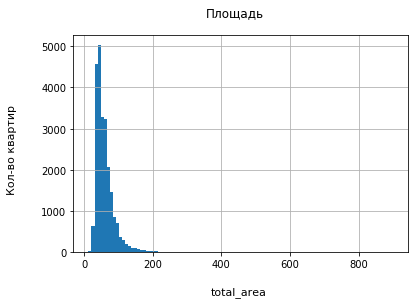

In [10]:
#В графиках в диапазоне указал минимальное и максимальное значения из метода describe

#Функция рисующая график. Аргументы: 1 - датафрейм, 2 - колонка, 3 - заголовок, 4 - название оси у.
def drawHist(dataframe,column,title,y_text):
    dmax = dataframe[column].describe()['max']
    dmin = dataframe[column].describe()['min']
    if dmax >= 100:
        dbin = 100
    else:
        dbin = 10
    y, x, _ = plt.hist(dataframe[column],bins=dbin,range = (dmin,dmax))
    plt.grid()
    plt.suptitle(title)
    plt.text(x.max()/2, y.max()*-0.2, column, ha='center',fontsize=11)
    plt.text(x.max()*-0.25, y.max()/2, y_text, va='center', rotation='vertical',fontsize=11)

    
drawHist(data,'total_area','Площадь','Кол-во квартир')

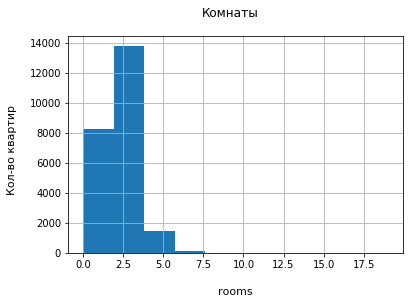

In [11]:
drawHist(data,'rooms','Комнаты','Кол-во квартир')

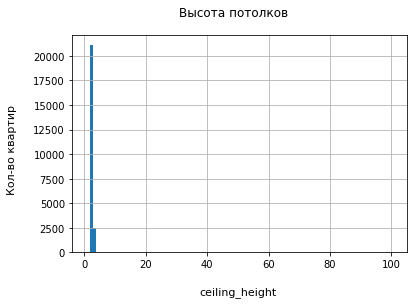

In [12]:
drawHist(data,'ceiling_height','Высота потолков','Кол-во квартир')

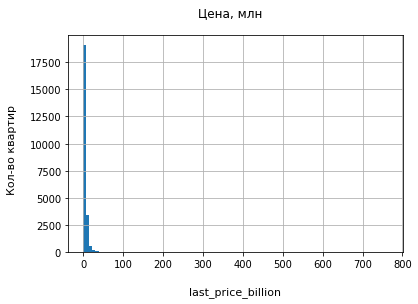

In [13]:
drawHist(data,'last_price_billion','Цена, млн','Кол-во квартир')

### Вывод

Проверив диапазоны значений, можно точно сказать, что с данными непорядок. Графики лишь подтверждают вывод сделанный в прошлом пункте.

<a id='step_43'></a>
#### 4.3 Изучение времени продажи квартир.

,days_exposition
count,20518.000000
mean,180.888634
std,219.727988
min,1.000000
25%,45.000000
50%,95.000000
75%,232.000000
max,1580.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e78f50090>]],
      dtype=object)

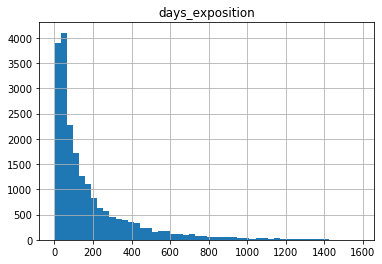

In [14]:
#Отсеял непроданные квартиры выбрав только значения в столбце больше 0
sold = data.query('days_exposition > 0')['days_exposition'].to_frame()
sold.describe()
sold.hist(bins=50,range = (1, 1580))

(-100, 800)

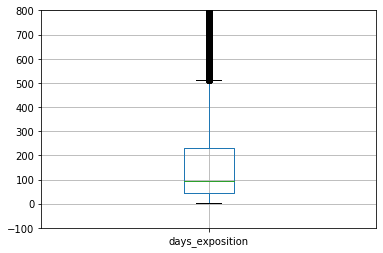

In [15]:
sold.boxplot(column='days_exposition')
plt.ylim(-100, 800)
plt.show()

### Вывод

По результатам метода describe() видно, что среднее значение равно 180.888634, а медиана равна 95.

Обычно продажа квартир занимает от 45 до 232 дней, в среднем 95 дней. Всё что меньше 45 дней можно считать быстрой продажей, а то что больше 232 дней - долгой.

<a id='step_44'></a>
#### 4.4 Удаление редких и выбивающихся значений.

In [16]:
count_before = data['total_area'].count()

,rooms
count,23699.000000
mean,2.070636
std,1.078405
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,19.000000


(0, 10)

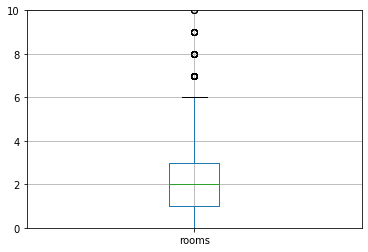

,rooms
count,23609.000000
mean,2.056250
std,0.993824
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,6.000000


(0, 10)

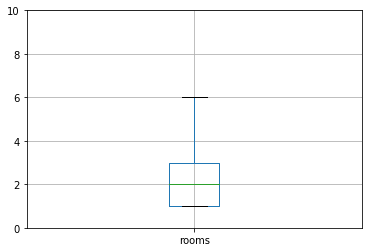

In [17]:
area_count = data['rooms'].to_frame()
area_count.describe()
area_count.boxplot(column='rooms')
plt.ylim(0, 10)
plt.show()

#Значения 0 для комнат заменил по моде жилой площади.
data['rooms'] = data['rooms'].replace(0, mode(data[(data['living_area'] == data['living_area'])&(data['rooms'] > 0)]['rooms']))

#Создал новую таблицу df убрав из основного датафрейма выбросы.
df = data.query('rooms <= 6')

area_count = df['rooms'].to_frame()
area_count.describe()
area_count.boxplot(column='rooms')
plt.ylim(0, 10)
plt.show()

,ceiling_height
count,23609.000000
mean,2.664448
std,0.996385
min,1.000000
25%,2.500000
50%,2.500000
75%,2.700000
max,100.000000


(0, 4)

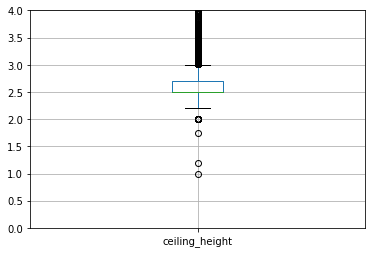

,ceiling_height
count,23559.000000
mean,2.636300
std,0.235516
min,2.200000
25%,2.500000
50%,2.500000
75%,2.700000
max,5.000000


(0, 4)

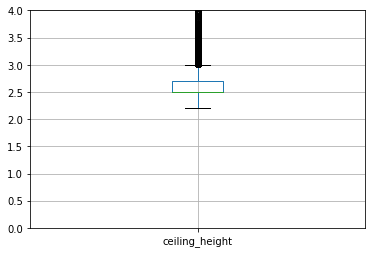

In [18]:
area_count = df['ceiling_height'].to_frame()
area_count.describe()
area_count.boxplot(column='ceiling_height')
plt.ylim(0, 4)
plt.show()

#Отсеял неправдоподобно маленькие и большие значения. 
#Петербург знаменит квартирами с высокими потолками, поэтому отсев верхних значений установил от 5м.
df = df.query('ceiling_height <= 5 and ceiling_height >= 2.2')

area_count = df['ceiling_height'].to_frame()
area_count.describe()
area_count.boxplot(column='ceiling_height')
plt.ylim(0, 4)
plt.show()

,total_area
count,23559.000000
mean,59.487820
std,31.872001
min,12.000000
25%,40.000000
50%,52.000000
75%,69.200000
max,507.000000


(-10, 150)

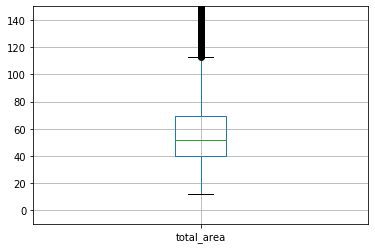

In [19]:
area_count = df['total_area'].to_frame()
area_count.describe()
area_count.boxplot(column='total_area')
plt.ylim(-10, 150)
plt.show()
#temp = df.groupby('name')['prop'].describe().reset_index()
# df = df.query('total_area <= 300')

# area_count = df['total_area'].to_frame()
# area_count.describe()
# area_count.boxplot(column='total_area')
# plt.ylim(-10, 150)
# plt.show()

Самая маленькая квартира-студия в Питере 12м<sup>2</sup>. Это правда, такая квартира существует и является редким значением в данном наборе данных.<br>
Верхний ус показывает значение около 120м<sup>2</sup>, что странно. Попробуем сделать детализацию с группировкой по комнатам.

**1 комнатные квартиры**

,total_area,total_area_new
count,8225.000000,7996.000000
mean,37.442289,36.677475
std,10.131574,5.964422
min,12.000000,18.800000
25%,32.070000,32.000000
50%,36.300000,36.000000
75%,41.000000,40.600000
max,494.100000,54.350000


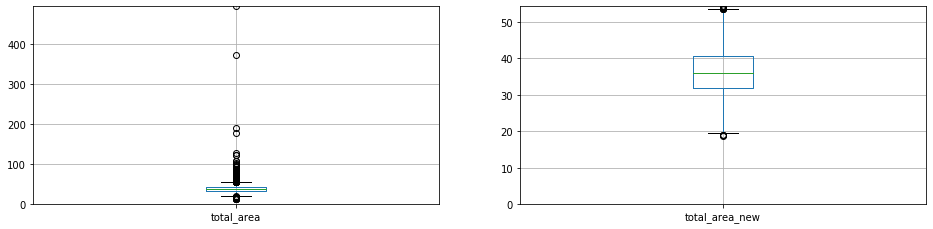

**2 комнатные квартиры**

,total_area,total_area_new
count,7923.000000,7691.000000
mean,55.857833,54.476361
std,13.196320,10.241711
min,20.000000,24.000000
25%,46.000000,46.000000
50%,53.000000,53.000000
75%,62.000000,60.800000
max,196.000000,86.000000


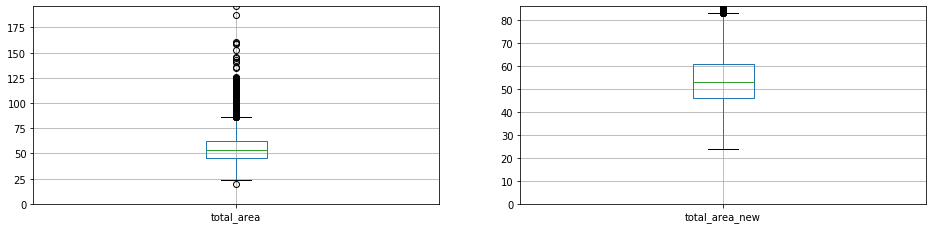

**3 комнатные квартиры**

,total_area,total_area_new
count,5805.000000,5567.000000
mean,77.767626,74.585024
std,23.260148,16.457958
min,40.100000,40.100000
25%,62.000000,61.400000
50%,73.000000,72.000000
75%,87.000000,84.300000
max,363.100000,124.500000


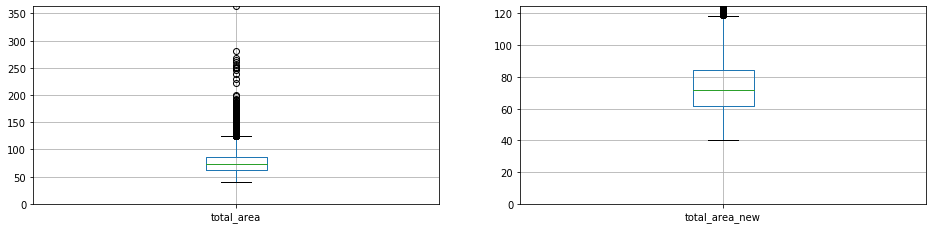

**4 комнатные квартиры**

,total_area,total_area_new
count,1178.000000,1132.000000
mean,107.551019,101.900106
std,44.494824,32.548479
min,42.000000,42.000000
25%,77.800000,77.000000
50%,99.300000,98.000000
75%,125.250000,120.175000
max,500.000000,196.000000


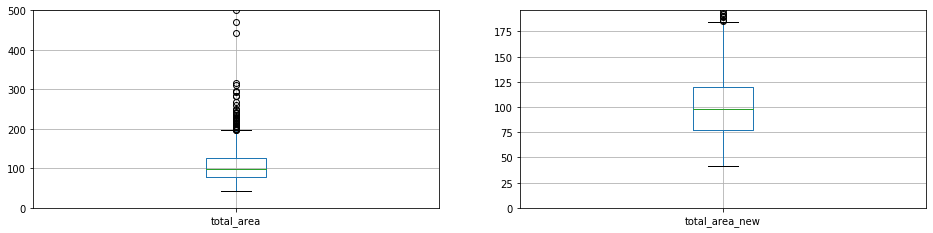

**5 комнатные квартиры**

,total_area,total_area_new
count,324.000000,304.000000
mean,160.283302,147.807533
std,67.747711,44.858447
min,40.000000,40.000000
25%,117.250000,115.750000
50%,145.700000,143.000000
75%,181.200000,172.775000
max,507.000000,275.000000


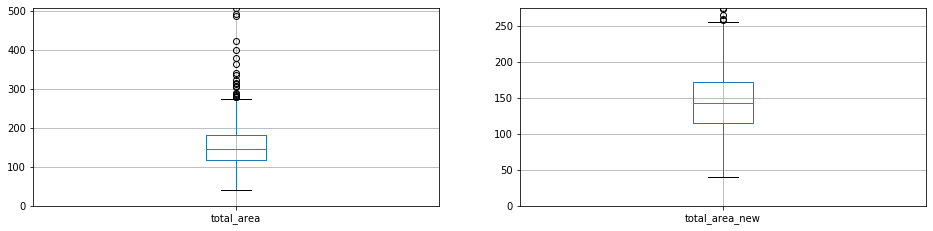

**6 комнатные квартиры**

,total_area,total_area_new
count,104.000000,99.000000
mean,200.780288,189.175253
std,77.798193,58.602421
min,87.000000,87.000000
25%,152.000000,151.900000
50%,184.000000,181.500000
75%,232.400000,222.500000
max,500.000000,327.200000


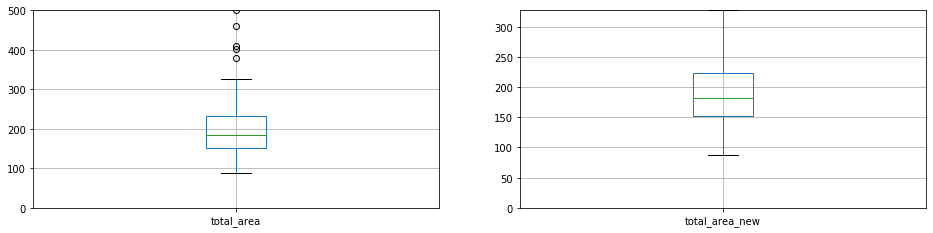



Общие данные площадей после проделанной работы.


,total_area
count,22789.000000
mean,57.329342
std,26.771133
min,18.800000
25%,40.000000
50%,51.000000
75%,67.500000
max,327.200000


(-10, 150)

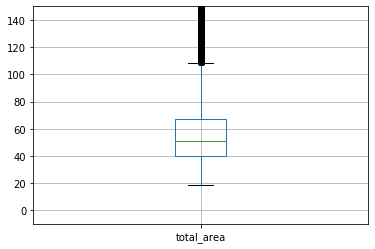

In [20]:
#Создал пустой датафрейм с колонками основного
df_new = df.query('rooms == -999')

#Автоматизировал процесс отсева выбросов и редких значений через функцию
#Функция plotScissor принимает аргументы: 
# 1. колонку,по которой будет строиться диаграмма; 
# 2. аргумент query() для фильтрации;
# 3. датафрейм;
def plotScissor(column,query,dataframe):
    col = df.query(query)[column].to_frame() #Колонку отфильтровал по переданному аргументу, превратил в dataframe и записвал в col 
    temp = col.describe() #Записал describe() для col в переменную temp
    temp_1q = temp[column]['25%'] # Первый квартиль
    temp_3q = temp[column]['75%'] # Третий квартиль
    temp_max = temp[column]['max'] # Максимальное значение
    highPlot = temp_3q + (temp_3q - temp_1q)*1.5 # Верхнее(правое) значение усов
    lowPlot = temp_1q - (temp_3q - temp_1q)*1.5 # Нижнее(левое) значение усов

    #Задал размер диаграмм
    plt.subplots(figsize=(16, 8))

    #Ввел диаграмму показывающую текущие значения
    plt.subplot(221)
    col.boxplot(column=column)
    plt.ylim(0, temp_max)

    #Отсеял значения находящиеся за пределами усов, результат записал в новую переменную df_temp
    df_temp = dataframe.query(query+' and '+column+' <= @highPlot and '+column+' >= @lowPlot')

    #Описал новые данные и объеденил таблицы для наглядности результатов
    col_new = df_temp[column].to_frame()
    temp[column+"_new"] = col_new.describe()
    display(temp)
    
    #Ввел диаграмму показывающую значения после отсева, вывел результат обеих диаграмм
    plt.subplot(222)
    col_new.rename(columns={column: column+"_new"}).boxplot(column=column+"_new")
    plt.ylim(0, temp[column+"_new"]['max'])
    plt.show()
    
    global df_new
    if df_new.shape[0] == 0:
        df_new = df_temp
    else:
        df_new = df_new.append(df_temp)

#Записал массив со уникальными значениями в столбце `rooms`
rooms_unique = sorted(df['rooms'].unique())

#Применил функцию plotScissor с перебором по уникальным значениям количеств комнат в квартирах.
for item in rooms_unique:
    printmd('**{} комнатные квартиры**'.format(item))
    plotScissor('total_area','rooms == '+str(item),df)

print() 
print()
print('Общие данные площадей после проделанной работы.')
area_count = df_new['total_area'].to_frame()
area_count.describe()
area_count.boxplot(column='total_area')
plt.ylim(-10, 150)
plt.show()

In [21]:
df = df_new

**Цена за м2 в 1 комнатных квартирах**

,price_per_square,price_per_square_new
count,7996.000000,7671.000000
mean,100160.237114,99454.002485
std,32789.738145,24802.759687
min,11000.000000,35143.769968
25%,83631.818731,84587.407789
50%,100000.000000,100000.000000
75%,116014.971880,115052.405154
max,848484.848485,164285.714286


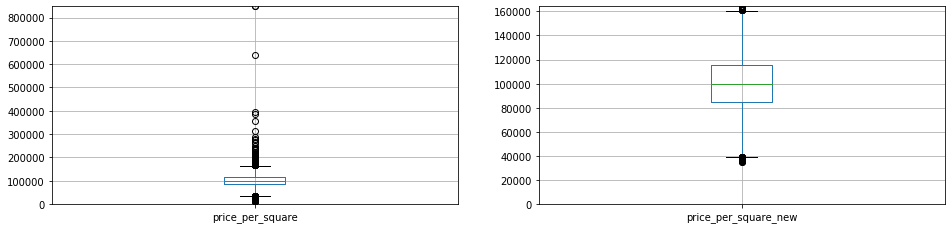

**Цена за м2 в 2 комнатных квартирах**

,price_per_square,price_per_square_new
count,7691.000000,7431.000000
mean,93427.565947,90335.598759
std,37369.727553,29440.374107
min,7962.962963,16346.153846
25%,72813.742008,72405.991574
50%,92156.862745,91346.153846
75%,110459.830867,108378.275550
max,612557.427259,166919.575114


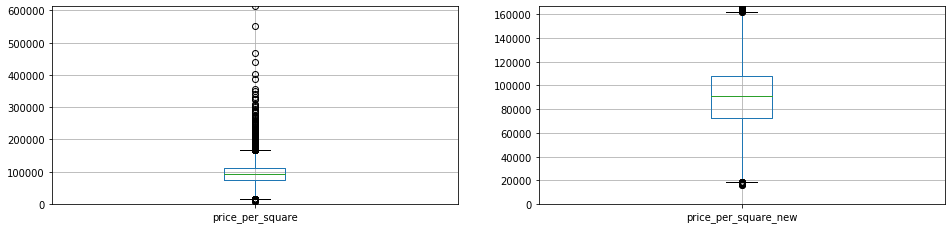

**Цена за м2 в 3 комнатных квартирах**

,price_per_square,price_per_square_new
count,5567.000000,5257.000000
mean,92898.754061,87487.145888
std,40959.596934,26935.230747
min,10897.435897,19014.084507
25%,71464.285714,70967.741935
50%,88135.593220,86989.409985
75%,106475.806452,102822.580645
max,719298.245614,158643.326039


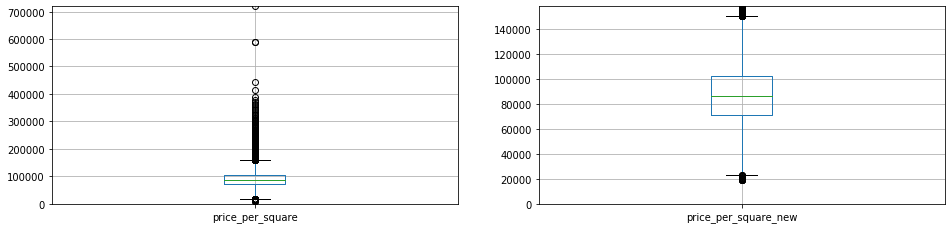

**Цена за м2 в 4 комнатных квартирах**

,price_per_square,price_per_square_new
count,1132.000000,1056.000000
mean,105507.945154,93891.417633
std,60235.990327,30203.011189
min,13483.146067,15861.571738
25%,76388.888889,75554.569654
50%,92059.576023,89598.183978
75%,117658.371041,110318.165659
max,995983.935743,179487.179487


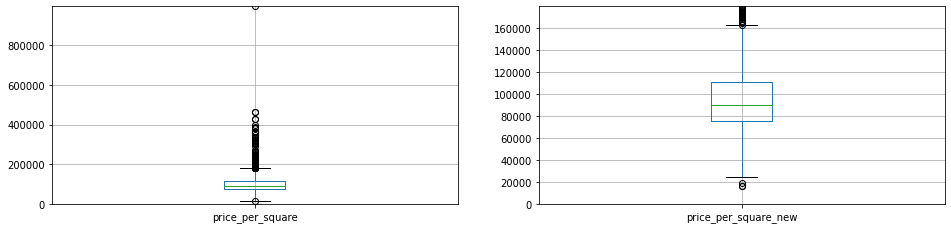

**Цена за м2 в 5 комнатных квартирах**

,price_per_square,price_per_square_new
count,304.000000,281.000000
mean,117574.518640,99326.407682
std,80868.026189,35623.142657
min,14347.826087,14347.826087
25%,78074.879227,76296.296296
50%,95610.732785,91666.666667
75%,126787.247746,117848.970252
max,658436.213992,199249.534012


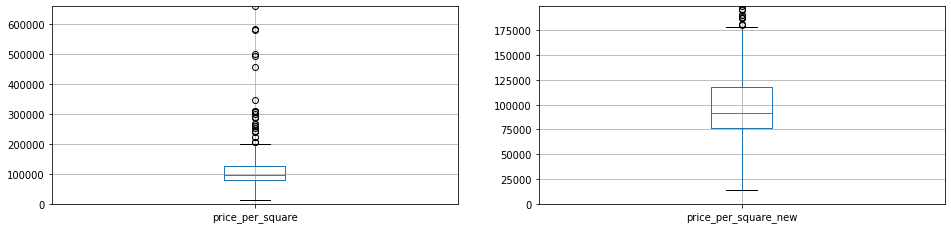

**Цена за м2 в 6 комнатных квартирах**

,price_per_square,price_per_square_new
count,99.000000,91.000000
mean,133638.748519,106585.714678
std,112219.689919,36534.114551
min,28919.631094,28919.631094
25%,85833.711434,84069.206601
50%,99370.652534,98009.478673
75%,140471.311475,122884.959313
max,857542.877144,218147.183688


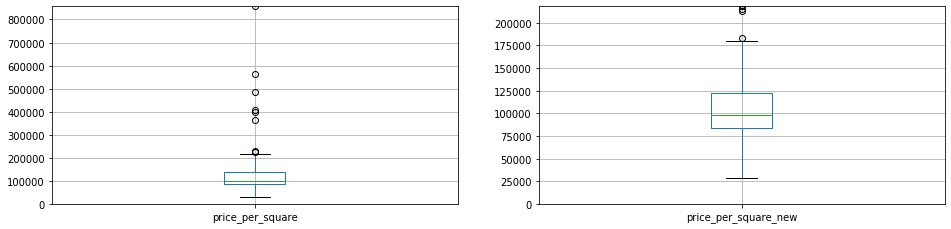

In [22]:
#Тоже самое проделал с ценой за квадратный метр
df_new = df.query('rooms == -999')

for item in rooms_unique:
    printmd('**Цена за м2 в {} комнатных квартирах**'.format(item))
    plotScissor('price_per_square','rooms == '+str(item),df)

In [23]:
df = df_new

In [24]:
count_after = df['total_area'].count()
print('Кол-во объявлений до:',count_before)
print('Кол-во объявлений после:',count_after)
print('Объявлений удалено:',count_before - count_after)

Кол-во объявлений до: 23699
Кол-во объявлений после: 21787
Объявлений удалено: 1912


### Вывод

Удалил 1912 объявления содержащие выбросы и редкие значения.<br><br>
Обнаружил:<br>
В основном квартиры имеют от одной до шести комнат.<br>
Уровень потолков распределяется от 2.2м до 5м. В Питере высокие потолки!<br>
Самая маленькая квартира в Питере плошадью 12м<sup>2</sup>

<a id='step_45'></a>
#### 4.5 Какие факторы больше всего влияют на стоимость квартиры.

                     ceiling_height  cityCenters_nearest  floor_group  \
ceiling_height       1.000000       -0.095327             0.028452      
cityCenters_nearest -0.095327        1.000000            -0.013301      
floor_group          0.028452       -0.013301             1.000000      
last_price_billion   0.389203        0.013407             0.059476      
rooms                0.221824       -0.054079             0.009756      
total_area           0.348566       -0.061660             0.043320      

                     last_price_billion     rooms  total_area  
ceiling_height       0.389203            0.221824  0.348566    
cityCenters_nearest  0.013407           -0.054079 -0.061660    
floor_group          0.059476            0.009756  0.043320    
last_price_billion   1.000000            0.581467  0.833663    
rooms                0.581467            1.000000  0.823577    
total_area           0.833663            0.823577  1.000000    


('last_price_billion', ['Цена,млн', ''])

Text(0.5, 0, 'Цена, млн')

Text(0, 0.5, 'Площадь')

Text(0.5, 0.98, 'Влияние площади на цену')

Text(0.5, 0, 'Цена, млн')

Text(0, 0.5, 'Кол-во комнат')

Text(0.5, 0.98, 'Влияние кол-ва комнат на цену')

Text(0.5, 0, 'Цена, млн')

Text(0, 0.5, 'Этажность')

Text(0.5, 0.98, 'Влияние этажности на цену')

Text(0.5, 0, 'Цена, млн')

Text(0, 0.5, 'Расстояние до центра')

Text(0.5, 0.98, 'Влияние расстояния до центра на цену')

Text(0.5, 0, 'Цена, млн')

Text(0, 0.5, 'Высота потолков')

Text(0.5, 0.98, 'Влияние высоты потолков на цену')

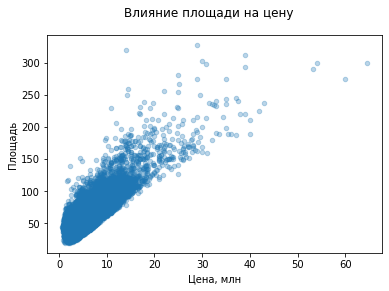

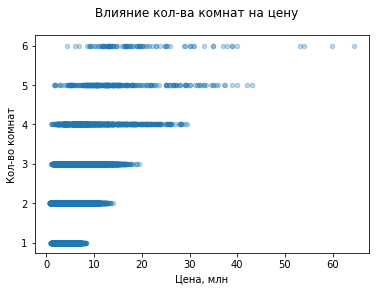

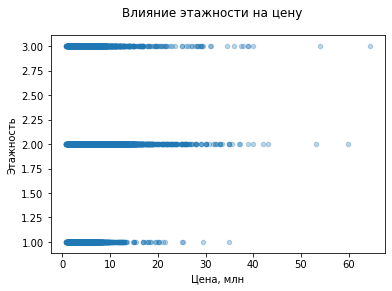

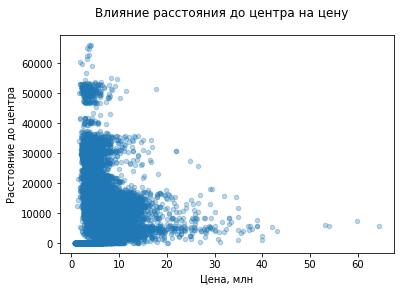

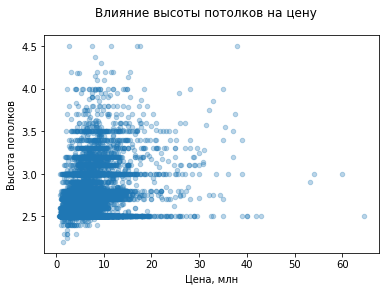

In [25]:
corr_arr = {'total_area': ['Площадь','Влияние площади на цену'],'rooms': ['Кол-во комнат','Влияние кол-ва комнат на цену'],'floor_group':['Этажность','Влияние этажности на цену'],'cityCenters_nearest':['Расстояние до центра','Влияние расстояния до центра на цену'],'ceiling_height':['Высота потолков','Влияние высоты потолков на цену'],'last_price_billion':['Цена,млн','']}

price_correlation = df.pivot_table(index=df.index,values=corr_arr)
print(price_correlation.corr())
corr_arr.popitem()
for col in corr_arr:
    df.plot(x='last_price_billion',y=col,kind='scatter', alpha=0.3)
    plt.xlabel('Цена, млн')
    plt.ylabel(corr_arr[col][0])
    plt.suptitle(corr_arr[col][1])

                  day_of_week  last_price     month  price_per_square  \
day_of_week       1.000000    -0.019038    0.013367 -0.010355           
last_price       -0.019038     1.000000    0.002730  0.557792           
month             0.013367     0.002730    1.000000 -0.004992           
price_per_square -0.010355     0.557792   -0.004992  1.000000           
year             -0.004513    -0.027052   -0.269580  0.065335           

                      year  
day_of_week      -0.004513  
last_price       -0.027052  
month            -0.269580  
price_per_square  0.065335  
year              1.000000  


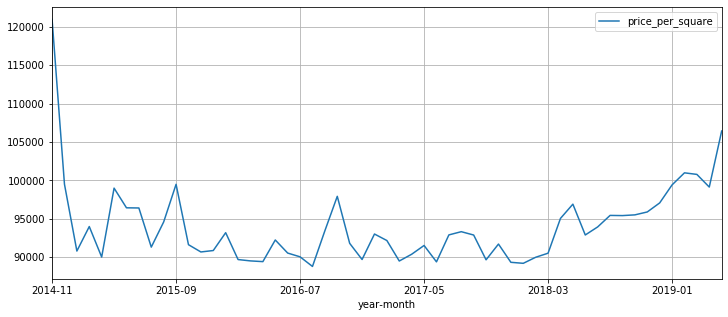

In [26]:
corr_arr = ['first_day_exposition','day_of_week','month','year','last_price','price_per_square']
df['fde_int'] = df['first_day_exposition'].astype('int64')

price_correlation = df.pivot_table(index=df.index,values=corr_arr)
print(price_correlation.corr())
df.loc[:,'year-month'] = df['first_day_exposition'].apply(lambda x: x.strftime('%Y-%m'))
(df
 .pivot_table(index='year-month',values='price_per_square')
 .plot(grid=True,figsize=(12, 5))
)

In [27]:
pps_mean_start = df.query('year-month == 2014-11')['price_per_square'].mean()
print('Средняя цена за м2 в ноябре 2014 года:',pps_mean_start)
print()
pps_mean_end = df.query('year-month == 2019-1')['price_per_square'].mean()
print('Средняя цена за м2 в январе 2019 года:',pps_mean_end)
print()
print('Процент изменения цен за указанный период {:.2f}%'.format((pps_mean_end - pps_mean_start) * 100 / pps_mean_end))

Средняя цена за м2 в ноябре 2014 года: 93240.6419101234

Средняя цена за м2 в январе 2019 года: 99414.63727733995

Процент изменения цен за указанный период 6.21%


In [28]:
printmd('*10 населённых пунктов с наибольшим числом объявлений*')
places = df['locality_name'].value_counts().sort_values(ascending=False)
places.head(10)
printmd('*Средняя цена за квадратный метр*')
for i in range(0,10):
    place = places.index[i]
    print('{}: {:.0f}'.format(place,df.query('locality_name == @place')['price_per_square'].mean()))

*10 населённых пунктов с наибольшим числом объявлений*

Санкт-Петербург      14204
посёлок Мурино       517  
посёлок Шушары       432  
Всеволожск           390  
Пушкин               344  
Колпино              332  
посёлок Парголово    321  
Гатчина              301  
деревня Кудрово      298  
Выборг               227  
Name: locality_name, dtype: int64

*Средняя цена за квадратный метр*

Санкт-Петербург: 105556
посёлок Мурино: 85769
посёлок Шушары: 78806
Всеволожск: 67476
Пушкин: 101659
Колпино: 75468
посёлок Парголово: 90760
Гатчина: 69160
деревня Кудрово: 92455
Выборг: 58765


### Вывод

<table align="left" style="align:left;border: 1px solid black !important;">
    <tr style="align:left;border: 1px solid black !important;">
      <td><b></b></td>
       <td><b>ceiling_height</b></td>
      <td><b>cityCenters_nearest</b></td>
      <td><b>floor_group</b></td>
      <td style="text-align: left;"><b>rooms</b></td>
      <td style="text-align: left;"><b>total_area</b></td>
    </tr>
  <tr>
      <td style="text-align: right;"><b>last_price</b></td>
    <td>0.389203</td> 
    <td>0.013407</td>     
    <td>0.056979</td>
    <td>0.581467</td>
    <td>0.833663</td>
  </tr>
</table>           
<br>                            
<br>
<br>
Коэффициенты корелляции показывают большую зависимость между ценой и общей площадью квартиры, результат 0.83.<br>
Так же есть зависимость послабее, на уровне 0.58, между ценой и количеством комнат.<br>
Параметр `cityCenters_nearest` не оказывает большого влияния на цену, так же как и параметр `floor_group`. Для них показатели 0.013 и 0.056.<br>
Есть странность в положительной корреляции между расстоянием до центра и ценой. Возможно дело в престижных загородных участках.<br>
<br>
<table align="left" style="align:left;border: 1px solid black !important;">
    <tr style="align:left;border: 1px solid black !important;">
        <td><b></b></td>
        <td><b>day_of_week</b></td>
        <td><b>fde_int</b></td>
        <td style="text-align: left;"><b>month</b></td>
        <td style="text-align: left;"><b>year</b></td>
    </tr>
    <tr>
        <td style="text-align: right;"><b>last_price</b></td>
        <td>-0.019038</td>           
        <td>-0.027301</td>
        <td>0.002730</td>
        <td>-0.027052</td>
    </tr>
</table>
<br>                            
<br>
<br>
<br> 
В этом периоде данных, с 2014 по 2019 годы, большой зависимости между датой размещения и ценой нет. Более влиятельным показателем на цену является параметр года с коэффициентом -0.027. Это может указывать на динамику роста цен в целом. Так же видно, что с ноября 2014 по январь 2019 года цена за м2 в среднем выросла на 6.21%
<br>
<br>
Самая высокая средняя цена 105 556 руб. за квадратный метр находится в Санкт-Петербурге.<br>
А самая низкая в Выборге, со средней ценой 58 765 руб./м<sup><small>2</small>.

<a id='step_46'></a>
#### 4.6 Изучение расстояния до центра квартир в Санкт-Петербурге.

In [29]:
spbflats = df.query('locality_name == "Санкт-Петербург" and cityCenters_nearest > 0').reset_index(drop=True)
print('Количество объявлений в Санкт-Петербурге: {:}'.format(spbflats['locality_name'].count()))

Количество объявлений в Санкт-Петербурге: 14164


In [30]:
#Из-за погрещности в округлении round()(округляет по банковским правилам) добавил функцию,
#которая округляет по правилам математики
def my_round(num, n):
    x = num * 10**n
    d = x - x
    return np.where((d>=0.5) | ((d>-0.5) & (d <=0)), np.ceil(x), np.floor(x)) / 10**n

#Перевел дистанцию из метров в километры, записал результат в колонку `center_distance_km`
spbflats.loc[:,'center_distance_km'] = spbflats['cityCenters_nearest'].apply(lambda x: my_round(x / 1000,0))

#Посчитал цену за каждый километр
spbflats.loc[:,'price_per_km'] = spbflats.apply(lambda x: x['last_price_billion'] / x['center_distance_km'], axis=1)

#Проверил результат
spbflats[['cityCenters_nearest','center_distance_km','price_per_km','last_price_billion']].head(5)

,cityCenters_nearest,center_distance_km,price_per_km,last_price_billion
0,13878,14.0,0.360714,5.05
1,14259,15.0,0.310000,4.65
2,14616,15.0,0.278667,4.18
3,10842,11.0,0.295455,3.25
4,9722,10.0,0.320000,3.20


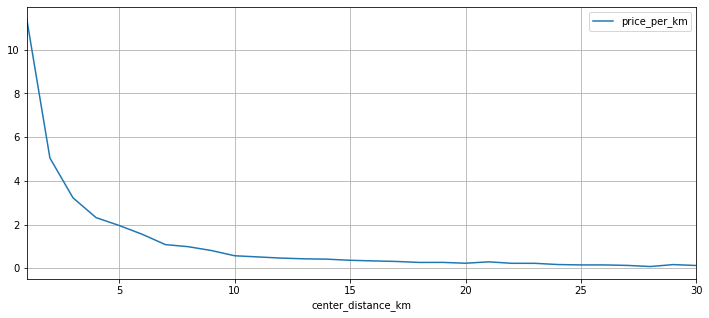

In [31]:
#Построил график показывающий зависимость между ценой за километр и расстоянием до центра.
(spbflats
 .pivot_table(index='center_distance_km',values='price_per_km')
 .plot(grid=True,figsize=(12, 5))
)

### Вывод

По графику видно, что цена за м<sup>2</sup> перестает существенно снижаться после расстояния 10км от центра. Эта информация находит подтверждение в том, что примерно на этом расстоянии от центра проложена линия КАД.

<a id='step_47'></a>
#### 4.7 Анализ сегмента квартир в центре.

In [32]:
#Отфильтруем квартиры в центре найденной величиной
spb_center = spbflats.query('center_distance_km < 10')
print('Количество квартир в центре Санкт-Петербурга:',spb_center['price_per_km'].count())

spb_center['last_price_billion'].to_frame('Цена, млн').describe()

spb_center['total_area'].to_frame('Общая площадь').describe()
spb_center['rooms'].to_frame('Кол-во комнат').describe()
spb_center['ceiling_height'].to_frame('Высота потолка').describe()
#spb_center['center_distance'].to_frame('Удаленность от центра').describe()
#data['first_day_exposition'] = spb_center['first_day_exposition'].astype('datetime')
#spb_center['first_day_exposition'].to_frame('Дата размещения').describe()

Количество квартир в центре Санкт-Петербурга: 3293


,"Цена, млн"
count,3293.000000
mean,8.846306
std,5.198435
min,1.800000
25%,5.700000
50%,7.685993
75%,10.500000
max,64.500000


,Общая площадь
count,3293.000000
mean,77.718709
std,38.462584
min,19.000000
25%,50.000000
50%,70.000000
75%,94.000000
max,312.000000


,Кол-во комнат
count,3293.000000
mean,2.673246
std,1.196442
min,1.000000
25%,2.000000
50%,3.000000
75%,3.000000
max,6.000000


,Высота потолка
count,3293.000000
mean,2.828767
std,0.367896
min,2.400000
25%,2.500000
50%,2.710000
75%,3.070000
max,4.500000


                     ceiling_height  cityCenters_nearest  floor_group  \
ceiling_height       1.000000       -0.251911             0.035564      
cityCenters_nearest -0.251911        1.000000            -0.039520      
floor_group          0.035564       -0.039520             1.000000      
last_price           0.241435       -0.185014             0.126490      
rooms                0.283171       -0.287910             0.095839      
total_area           0.289664       -0.258073             0.118868      

                     last_price     rooms  total_area  
ceiling_height       0.241435    0.283171  0.289664    
cityCenters_nearest -0.185014   -0.287910 -0.258073    
floor_group          0.126490    0.095839  0.118868    
last_price           1.000000    0.662823  0.867253    
rooms                0.662823    1.000000  0.854035    
total_area           0.867253    0.854035  1.000000    


'last_price'

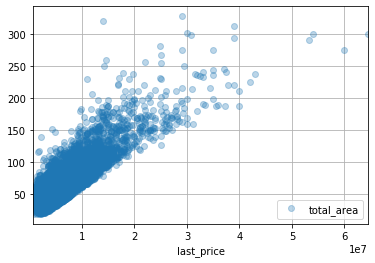

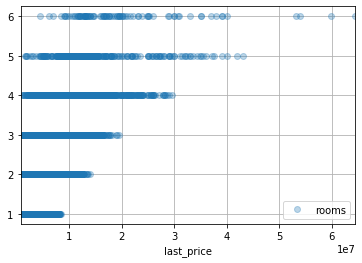

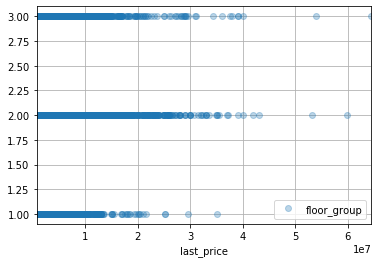

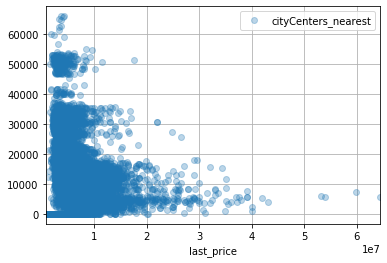

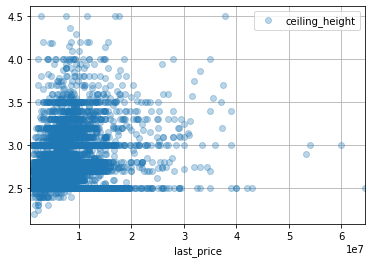

In [33]:
spb_corr_arr = ['total_area','rooms','floor_group','cityCenters_nearest','ceiling_height','last_price']

price_correlation = spb_center.pivot_table(index=spb_center.index,values=spb_corr_arr)
print(price_correlation.corr())
spb_corr_arr.pop()
for col in spb_corr_arr:
    df.plot(x='last_price',y=col,style='o',grid=True, alpha=0.3)

In [34]:
printmd('*Средняя цена за квадратный метр в центре Санкт-Петербурга*')
round(spb_center['price_per_square'].mean())

*Средняя цена за квадратный метр в центре Санкт-Петербурга*

114580

<table align="left" style="align:left;border: 1px solid black !important;">
    <tr style="align:left;border: 1px solid black !important;">
      <td><b>Зависимость от last_price</b></td>
       <td><b>ceiling_height</b></td>
      <td><b>cityCenters_nearest</b></td>
      <td><b>floor_group</b></td>
      <td style="text-align: left;"><b>rooms</b></td>
      <td style="text-align: left;"><b>total_area</b></td>
    </tr>
      <tr>
    <td style="text-align: right;"><b>центр Санкт-Петербурга</b></td>
    <td>0.241435</td> 
    <td>-0.185014</td>     
    <td>0.126490</td>
    <td>0.662823</td>
    <td>0.867253</td>
  </tr>
  <tr>
      <td style="text-align: right;"><b>по всей местности</b></td>
    <td>0.389203</td> 
    <td>0.013407</td>     
    <td>0.056979</td>
    <td>0.581467</td>
    <td>0.833663</td>
  </tr>

  <tr>
    <td style="text-align: right;"><b>разница</b></td>
    <td>0.147768</td> 
    <td>0.198421</td>     
    <td>0.069511</td>
    <td>0.081356</td>
    <td>0.033590</td>
  </tr>
</table>           
<br>                            
<br>
<br>
<br>
<br>
<br>

В отличии от всей местности показатели корелляции цены для центра выросли. Это ожидаемо, в центре цены на порядок выше.<br>
У квартир в центре более высокая зависимость цены от площади, количества комнат, этажности.
Но так же меньшая зависимость между ценой и высотой потолков. Так же показатель зависимости между ценой и расстоянием до центра сменился на отрицательный(чем больше цена, тем меньше расстояние).

<br>
<br>

In [35]:
spb_corr_arr = ['fde_int','day_of_week','month','year','price_per_square','last_price_billion']
df['fde_int'] = spb_center['first_day_exposition'].astype('int64')

price_correlation = spb_center.pivot_table(index=spb_center.index,values=spb_corr_arr)
print(price_correlation.corr())

                    day_of_week   fde_int  last_price_billion     month  \
day_of_week         1.000000    -0.002603 -0.028690            0.036696   
fde_int            -0.002603     1.000000 -0.047451            0.004136   
last_price_billion -0.028690    -0.047451  1.000000           -0.007159   
month               0.036696     0.004136 -0.007159            1.000000   
price_per_square    0.014410     0.089931  0.382875           -0.023381   
year               -0.010637     0.966361 -0.044562           -0.252312   

                    price_per_square      year  
day_of_week         0.014410         -0.010637  
fde_int             0.089931          0.966361  
last_price_billion  0.382875         -0.044562  
month              -0.023381         -0.252312  
price_per_square    1.000000          0.092994  
year                0.092994          1.000000  


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


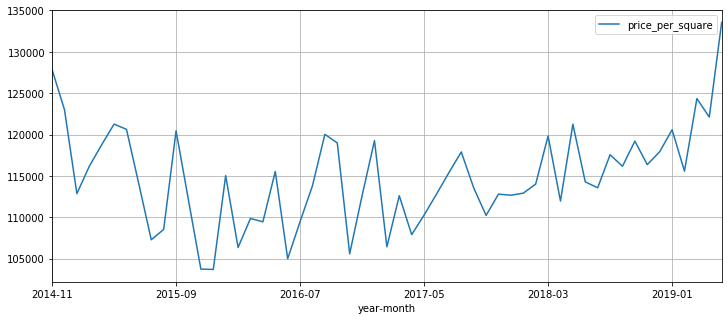

In [36]:
spb_center.loc[:,'year-month'] = spb_center['first_day_exposition'].apply(lambda x: x.strftime('%Y-%m'))
(spb_center
 .pivot_table(index='year-month',values='price_per_square')
 .plot(grid=True,figsize=(12, 5))
)

In [37]:
pps_mean_start = spb_center.query('year-month == 2014-11')['price_per_square'].mean()
print('Средняя цена за м2 в ноябре 2014 года:',pps_mean_start)
print()
pps_mean_end = spb_center.query('year-month == 2019-1')['price_per_square'].mean()
print('Средняя цена за м2 в январе 2019 года:',pps_mean_end)
print()
print('Процент изменения цен за указанный период {:.2f}%'.format((pps_mean_end - pps_mean_start) * 100 / pps_mean_end))

Средняя цена за м2 в ноябре 2014 года: 106960.20241507827

Средняя цена за м2 в январе 2019 года: 120573.52790983698

Процент изменения цен за указанный период 11.29%


<table align="left" style="align:left;border: 1px solid black !important;">
    <tr style="align:left;border: 1px solid black !important;">
        <td><b>Зависимость от last_price</b></td>
        <td><b>day_of_week</b></td>
        <td><b>fde_int</b></td>
        <td style="text-align: left;"><b>month</b></td>
        <td style="text-align: left;"><b>year</b></td>
    </tr>
    <tr>
        <td style="text-align: right;"><b>центр Санкт-Петербурга</b></td>
        <td>-0.028690</td>           
        <td>-0.047451</td>
        <td>-0.007159</td>
        <td>-0.044562</td>
    </tr>
    <tr>
        <td style="text-align: right;"><b>по всей местности</b></td>
        <td>-0.019038</td>           
        <td>-0.027301</td>
        <td>0.002730</td>
        <td>-0.027052</td>
    </tr>
    <tr>
        <td style="text-align: right;"><b>разница</b></td>
        <td>0.009652</td>           
        <td>0.020150</td>
        <td>0.009889</td>
        <td>0.017510</td>
    </tr>
</table>
<br>                            
<br>
<br>
<br> 
<br>
<br>

В этом периоде данных для центра Санкт-Петерубрга, с 2014 по 2019 годы, показатели зависимости между датой размещения и ценой выше, чем по местности в целом. Однако коэффициент корреляции всё еще слишком низок.<br><br>
С ноября 2014 по январь 2019 года цена за м<sup>2</sup> по центру в среднем выросла на 11.29% 
<br>

,days_exposition
count,2839.000000
mean,233.626981
std,269.576507
min,3.000000
25%,54.000000
50%,122.000000
75%,318.000000
max,1512.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e7889b790>]],
      dtype=object)

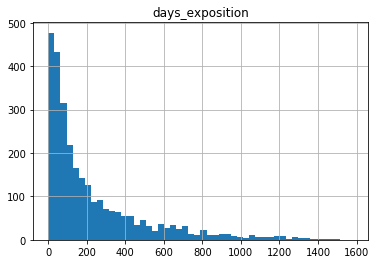

In [38]:
sold = spb_center.query('days_exposition > 0')['days_exposition'].to_frame()
sold.describe()
sold.hist(bins=50,range = (1, 1580))

(-100, 800)

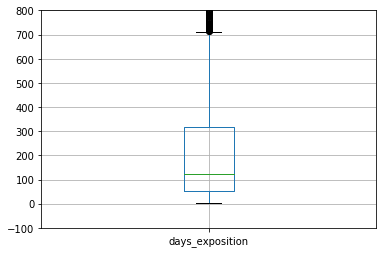

In [39]:
sold.boxplot(column='days_exposition')
plt.ylim(-100, 800)
plt.show()

### Вывод

Квартиры в центре продаются в среднем 122 дня, что на 27 дней дольше, чем по всей местности.<br>
Порог быстрых продаж - 54 дня, а долгих - 318 дней. Для всей местности порог быстрых - 45, для долгих - 232.

По проведенному исследованию видно, что в центре квартиры на порядок дороже. На цену в первую очередь влияют площадь и количество комнат. Вторичными критериями являются высота потолка, этаж и расположение от центра. В центре влияние высоты потолка на цену менее значительное, чем для потолков всей местности. В отличии от центральной области значение корреляции удаленности от центра для всей местности положительное, что скорей всего связано с престижными районами в пригороде.

<a id='step_5'></a>
### 5. Общий вывод

В этом проекте, исследуя объявления о продажах квартир в Санкт-Петербурге и прилегающих к нёму соседних населённых пунтках, научился: строить графики по показателям, новым методам обработки пропусков, пользоваться срезами данных, писать функции автоматизирущие построение графиков, интерпретировать информацию по графикам и таблицам.